In [1]:
%pylab inline
import plot_surf_stat_map_3 as plot_surf
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import vtk

In [3]:
# Open mesh in ply format
def open_ply(filepath):
    import numpy
    f=open(filepath,'r');
    i=0;
    ip=0;
    it=0;
    np=0;
    nt=0;
    for str in f:
        i+=1;
        arr=str.split(" ");
        if(arr[0]=="element" and arr[1]=="vertex"):
            np=int(arr[2]);
            p=numpy.zeros((np,3));
        elif(arr[0]=="element" and arr[1]=="face"):
            nt=int(arr[2]);
            t=numpy.zeros((nt,3));
        elif(i>=11 and i<11+np):
            p[ip,0]=float(arr[0]);
            p[ip,1]=float(arr[1]);
            p[ip,2]=float(arr[2]);
            ip+=1;
        elif(i>=11+np and i<11+np+nt):
            t[it,0]=int(arr[1]);
            t[it,1]=int(arr[2]);
            t[it,2]=int(arr[3]);
            it+=1;
    mesh={};
    mesh["np"]=np;
    mesh["nt"]=nt;
    mesh["p"]=p;
    mesh["t"]=t;
    return mesh;

In [4]:
# find the node which is the closest to the given endpoint and return its id and distance to the endpoint
def findClosestNode(ep,tree):
    import scipy.spatial.distance as spdist    
    d_min = 100
    nid_min = -1
    #print 'ep',ep
    #for ep in endpoints:
    for j in range(len(tree.root.branches)):
        b = tree.root.branches[j]
        b_pos = b.position
        #print b_pos
        d = spdist.euclidean(b_pos,ep)
        #print d
        if d<=d_min :
            d_min = d
            nid_min = b.nid
    #print d_min,nid_min

    node_min = tree.getNodeFromId(nid_min)
    node_curr = node_min
    d_curr = 100
    nid_curr = -1
    while(not node_min.isLeaf):
        for j in node_min.branches:
            #b = tree.root.branches[j]
            b_pos = j.position
            #print b_pos
            d = spdist.euclidean(b_pos,ep)
            #print 'newly computed distance',d
            if (d<=d_curr) and not(j.isLeaf and not j.polyList) :
                #print 'new shorter distance than',d_curr
                d_curr = d
                nid_curr = j.nid
                node_curr = tree.getNodeFromId(nid_curr)
        #print 'current shortest distance and its node',d_curr,node_curr
        if (not node_min.polyList):
            #print 'no poly'
            d_min = d_curr
            nid_min = nid_curr
            node_min = node_curr
            d_curr = 100
            nid_curr = -1
        elif (node_curr == node_min) and (node_min.polyList):
            #print 'equal & poly'
            break
    
    #print d_min,nid_min
    return nid_min,d_min


In [5]:
# Normal of triangle a,b,c
def normal(a,b,c):
    v=np.cross(b-a,c-a)
    n=v/np.linalg.norm(v)
    return n;

# Compute the normals for each vertex in mesh
def normals(mesh):
    npt=mesh["np"];
    nt=mesh["nt"];
    pt=mesh["p"];
    t=mesh["t"];
    n=np.zeros((npt,3));
    for i in range(0,nt):
        nn=normal(pt[t[i,0]],pt[t[i,1]],pt[t[i,2]]);
        n[t[i,0]]=np.add(n[t[i,0]],nn);
        n[t[i,1]]=np.add(n[t[i,1]],nn);
        n[t[i,2]]=np.add(n[t[i,2]],nn);
    for i in range(0,npt):
        n[i]=n[i]/np.linalg.norm(n[i]);
    return n;

In [6]:
# find the closest point the mesh surface to the given endpoint using an octree 
def findClosestPoint(ep,ep1, mesh):
    import scipy.spatial.distance as spdist
#read mesh
    npt=mesh["np"];
    nt=mesh["nt"];
    pt=mesh["p"];
    t=mesh["t"];
    
#create tree
    t=t.astype(dtype=np.int32)

    from pyoctree import pyoctree as ot
    tree = ot.PyOctree(pt,t)

# Print out basic Octree data
    #print "Size of Octree               = %.3fmm" % tree.root.size
    #print "Number of Octnodes in Octree = %d" % tree.getNumberOfNodes()
    #print "Number of polys in Octree    = %d" % tree.numPolys
    
#find clostest node and the triangles in this node
    node_id,d_node = findClosestNode(ep,tree)
    t_index = tree.getNodeFromId(node_id).polyList

#look for the closest node within the preselected list of vertices
    #n=np.zeros((len(t_index),3));

    #print 't_index',t_index
        
    #n = normals(mesh)
    point = -1
    d = 1000000

    for i in t_index:
        
        #print 'i',i
        for k in range(3):

            #https://fr.wikipedia.org/wiki/Distance_d'un_point_%C3%A0_une_droite
            vAB = pt[t[i,k]]-ep
            vCA = ep-ep1
            d1 = np.linalg.norm(np.cross(vAB,vCA))/np.linalg.norm(vCA)
            
            if d1 < d:
                d = d1
                cp = pt[t[i,k]]
                point = t[i,k]
    #print d,point
    #print i
    return point,d, i

In [7]:
# read .ply mesh
pathDesktop = 'C:/Users/cdelettre/Desktop/'

subj = 'F25_P2'
path = 'E:/Celine/Ferret_b2n/'+subj+'/'
fmesh = path+subj+'_mesh.ply'
mesh = open_ply(fmesh)
npt=mesh["np"];
nt=mesh["nt"];
pt=mesh["p"];
t=mesh["t"];

In [8]:
print npt
print nt

1923
3858


In [9]:
# read the set of endpoints

fendpoints = path+subj+'_endpoints.txt'
endpoints = np.loadtxt(fendpoints)

In [10]:
endpoints.shape

(552880L, 3L)

In [ ]:
# "main" projects the set of endpoints onto the surface mesh
# output:
# 'points' = coordinates of the given projected endpoints
# 'ep_lab' = array containing the point id and its distance to the original endpoint

import time

ep_try = endpoints[0:300] #if only one point then: [endpoints[0]]
printInfos = False

ep_list = endpoints

ts = time.time()
#print 'ts', ts

ep_lab = np.zeros((len(ep_list)/2,2))
points = np.zeros((len(ep_list)/2,3))
triangles = np.zeros((len(ep_list)/2,2))

x=0
ep=0

#ep = endpoints[22]
while ep<(len(ep_list)):
    
    point,d_point,t_id = findClosestPoint(ep_list[ep],ep_list[ep+1],mesh)
    
    points[x]=pt[point]
    ep_lab[x,0]=point
    ep_lab[x,1]=d_point
    triangles[x,0] = t_id
    triangles[x,1] = d_point
    
    if (printInfos):
        print 'point coordinates:',ep
        #print 'node id:',node_id
        #print 'nb of vertices to be checked:',len(t_index)
        #print 'node distance:',d_node
        print 'point distance:',d_point,'point id:',point
        print '\n'
    
    x+=1
    #print 
    ep+=2
    
te = time.time()
#print 'te',te
print 'duration',te-ts,'s'

C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:42: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
ep_lab.shape

In [28]:
# compute sulcal shadows 

n = []
n = normals(mesh)
# vector point of view for shades // ex: [1,0,0] light from the front of the brain (X orientation)
vect = [1,0,0]
# if dot(a,b)=0 then a and b orthogonals
sulc = dot(n, vect)

C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\cdelettre\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


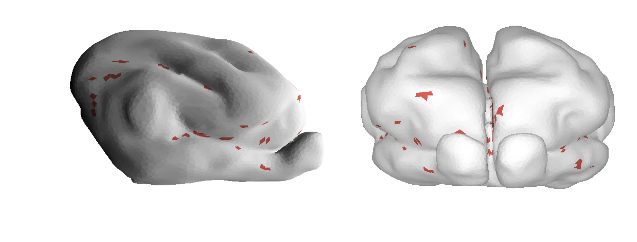

In [43]:
data = np.ones(mesh["np"])

sns.set_context('poster')
sns.set_style("white")

plot_surf.create_fig( coords=mesh["p"], faces=mesh["t"],  labels=[ep_lab[:,0]], sulc=sulc, azims=[90, 180], elevs=[0, 0], cpal='hls', cbar=True, alpha=1)
plt.savefig(path+subj+'_allep_2nd.png')

In [30]:
fep_lab = path+'projectedPoints-2pts-nb-dist.npz'
np.savez(fep_lab,ep_lab)

In [22]:
ep_labf = np.load(path+'projectedPoints-nb-dist_3.npz')
print ep_labf.files
ep_lab_3 = ep_labf['arr_0']
ep_lab_3.shape

['arr_0']


(990L, 2L)

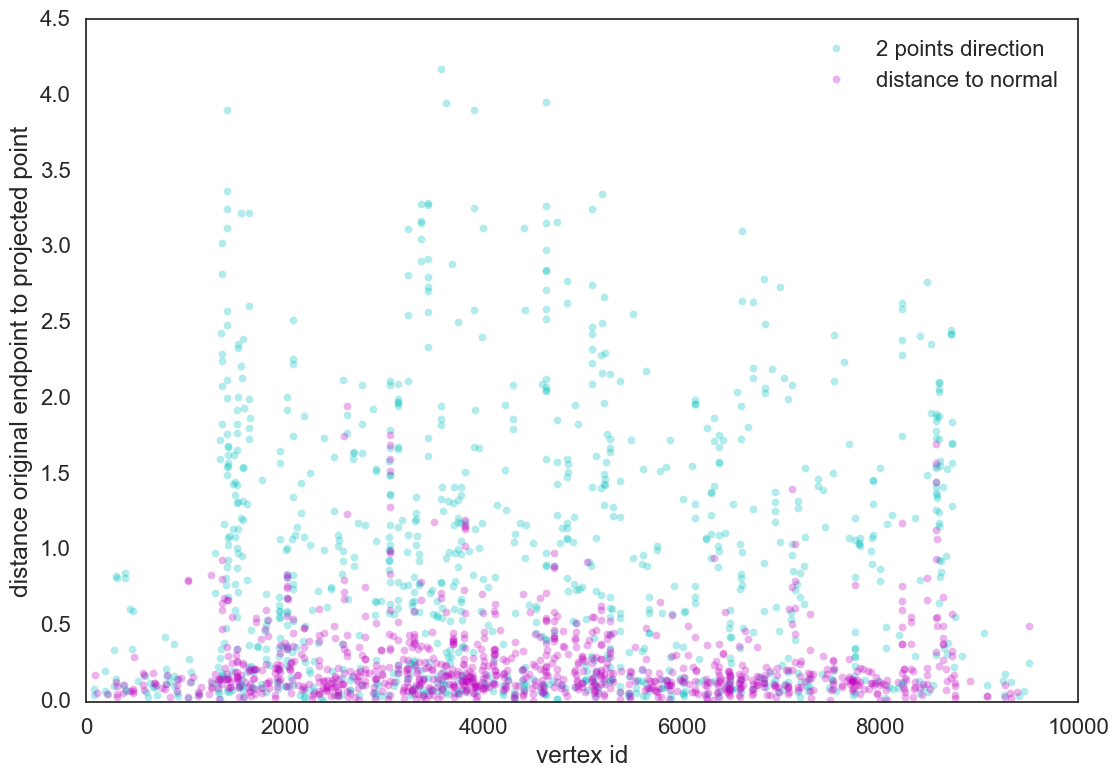

In [31]:
plt.plot(ep_lab[:,0],ep_lab[:,1],'.',alpha=0.3,c='c')
plt.plot(ep_lab_3[:,0],ep_lab_3[:,1],'.',alpha=0.3,c='m')
plt.legend(['2 points direction','distance to normal'])
plt.xlabel('vertex id')
plt.ylabel('distance original endpoint to projected point')

In [32]:
#how many unique points projected
xx =ep_lab[:,0]
print len(set(xx))
print len(xx)

608
990


In [33]:
ep_lab

array([[  3.44800000e+03,   1.55481033e-01],
       [  7.09000000e+02,   4.43391049e-02],
       [  1.48600000e+03,   1.62835232e+00],
       ..., 
       [  7.16300000e+03,   7.74646520e-01],
       [  9.40200000e+03,   3.61654309e-02],
       [  8.72500000e+03,   1.84555058e+00]])

In [38]:
# measure paired distance of the projected points from 2 methods (distance to normal and streamline direction)

epepdistance = np.zeros(len(ep_lab))
i =0
for i in range(len(ep_lab)):
    import scipy.spatial.distance as spdist
    epepdistance[i] = spdist.euclidean(pt[int(ep_lab[i,0])],pt[int(ep_lab_3[i,0])]) #euclidean distance point/endpoint

1.03178156623


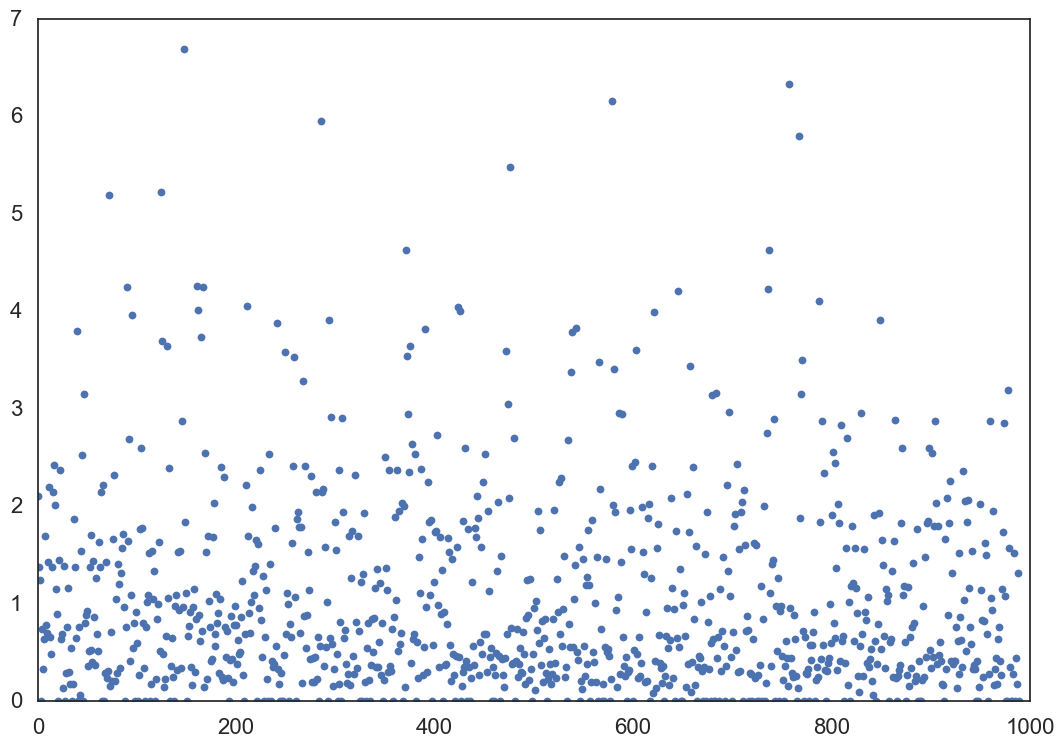

In [42]:
print epepdistance.mean()

plt.plot(epepdistance,'.')